In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as c
from astropy.time import Time

from sunpy.data import cache
from sunpy.coordinates import spice, frames
from sunpy.net import Fido
from sunpy.net.cdaweb import get_datasets
from sunpy.net.cdaweb import get_observatory_groups
from sunpy.time import parse_time
from sunpy.net import attrs as a
from sunpy.timeseries import TimeSeries

/Users/nathan/.pyenv/versions/3.13.7/envs/sun_capstone/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Keep this here for now, bad practice
import warnings
warnings.filterwarnings("ignore")

In [3]:
#tstart = parse_time("2021-05-28 01:00")
#tend = parse_time("2021-05-29 14:00")

start = '2024-04-08 00:00'
end = '2024-04-09 00:00'

# Select time period
tstart = parse_time(start)
tend = parse_time(end)

# Set data paths
psp_data_path = 'data/psp/'
solo_data_path = 'data/solo/'
ace_data_path = 'data/ace/'

# Step 1: Download time series data

We are looking for Solar wind speed ($V_{sw}$), Proton density ($n_p$), Proton Temperature ($T_p$) and Magnetic field components ($B_r$, $B_t$, $B_n$ and $B$) for spacecrafts PSP, SolO and ACE.

## Parker Solar Probe

In [4]:
# Find PSP datasets
psp_datasets = get_datasets('PSP')
psp_datasets[psp_datasets["Instruments"] == 'SWP_SPC']

Id,Instruments,Label,Start,End
str41,str30,str294,str24,str24
PSP_SWP_SPC_L3I,SWP_SPC,"Parker Solar Probe/SWEAP/SPC level 3 ion data - Michael L. Stevens (Center for Astrophysics, Harvard and Smithsonian)",2018-10-30T23:59:59.000Z,2025-07-31T23:59:30.000Z
PSP_SWP_SPC_L2I,SWP_SPC,"Parker Solar Probe/SWEAP/SPC Level 2 charge flux distributions - Michael L. Stevens (Center for Astrophysics, Harvard and Smithsonian)",2018-10-30T23:59:59.000Z,2025-07-31T23:59:30.000Z


In [5]:
psp_fields_ds = get_datasets('PSP_FLD')
psp_fields_ds[psp_fields_ds['Instruments'] == 'MAG_RTN_1min']

Id,Instruments,Label,Start,End
str31,str20,str249,str24,str24
PSP_FLD_L2_MAG_RTN_1MIN,MAG_RTN_1min,PSP FIELDS 1 minute cadence Fluxgate Magnetometer (MAG) data in RTN coordinates - Stuart D. Bale (bale@berkeley.edu) (UC Berkeley Space Sciences Laboratory),2018-10-02T03:48:30.000Z,2025-07-31T23:59:30.000Z


In [6]:
# Search and download sweap instrument data (every 30ish seconds)
res_psp_spc = Fido.search(a.Time(tstart, tend), a.cdaweb.Dataset('PSP_SWP_SPC_L3I'))
files_psp_spc = Fido.fetch(res_psp_spc, path=psp_data_path)

# Search and download Mag Data (1 minute)
res_psp_field = Fido.search(a.Time(tstart, tend), a.cdaweb.Dataset('PSP_FLD_L2_MAG_RTN_1MIN'))
files_psp_fields = Fido.fetch(res_psp_field, path=psp_data_path)

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.74file/s]


In [7]:
# Format Data for Plotting
psp_spc = TimeSeries(files_psp_spc, concatenate=True)
psp_fields_mag = TimeSeries(files_psp_fields, concatenate=True)

Mag data

<Axes: >

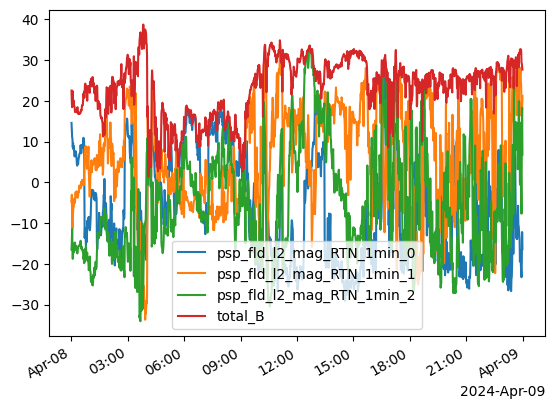

In [8]:
clean_psp = psp_fields_mag._data[psp_fields_mag._data["psp_fld_l2_quality_flags"].isnull()]
psp_fields_mag_clean = TimeSeries(clean_psp, psp_fields_mag.meta, psp_fields_mag.units)

total_B = np.sqrt(psp_fields_mag_clean.quantity('psp_fld_l2_mag_RTN_1min_0')**2 +
                  psp_fields_mag_clean.quantity('psp_fld_l2_mag_RTN_1min_1')**2 +
                  psp_fields_mag_clean.quantity('psp_fld_l2_mag_RTN_1min_2')**2)

psp_fields_mag_clean = psp_fields_mag_clean.add_column("total_B", total_B)

psp_fields_mag_clean.plot(columns=["psp_fld_l2_mag_RTN_1min_0", "psp_fld_l2_mag_RTN_1min_1", "psp_fld_l2_mag_RTN_1min_2", "total_B"])

Solar wind speed

In [9]:
bulk_speed_magnitude = np.sqrt(psp_spc._data["vp_moment_RTN_0"]**2 + 
                               psp_spc._data["vp_moment_RTN_1"]**2 + 
                               psp_spc._data["vp_moment_RTN_2"]**2)
psp_spc = psp_spc.add_column("bulk_vp_magnitude", bulk_speed_magnitude)

In [10]:
psp_spc._data

,DQF_0,DQF_1,DQF_2,DQF_3,DQF_4,DQF_5,DQF_6,DQF_7,DQF_8,DQF_9,...,wa_fit,wa_fit_uncertainty,wp1_fit,wp1_fit_uncertainty,wp_fit,wp_fit_uncertainty,wp_moment,wp_moment_deltahigh,wp_moment_deltalow,bulk_vp_magnitude
Epoch,,,,,,,,,,,,,,,,,,,,,
2024-04-08 00:00:03.385949824,1,1,0,0,0,0,1,1,1,1,...,NaN,NaN,409.830902,NaN,409.830902,NaN,NaN,NaN,NaN,NaN
2024-04-08 00:00:06.881210496,0,0,0,0,0,0,0,0,1,1,...,NaN,NaN,70.493240,2.019725,70.493240,2.019725,53.877686,118.399994,2.781710,378.163605
2024-04-08 00:00:34.843254656,0,0,0,0,0,0,0,0,1,1,...,NaN,NaN,70.501976,2.427776,70.501976,2.427776,54.563023,119.303413,2.878643,380.863007
2024-04-08 00:01:02.805338880,1,0,0,0,0,0,0,0,1,1,...,NaN,NaN,69.262871,2.368486,69.262871,2.368486,58.296349,0.575771,0.575771,373.996063
2024-04-08 00:01:09.795879936,0,0,0,0,0,0,0,0,1,1,...,NaN,NaN,35.024448,8.822251,39.637619,7.450294,41.629910,150.387177,11.788349,405.431061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-08 23:57:32.408190208,0,0,0,0,0,0,0,0,1,1,...,NaN,NaN,94.103981,6.870776,94.103981,6.870776,73.960831,150.878159,29.806976,535.750305
2024-04-08 23:58:00.370254464,0,0,0,0,0,0,0,0,1,1,...,NaN,NaN,93.052292,3.062078,93.052292,3.062078,75.391159,148.835632,28.614923,535.369202
2024-04-08 23:58:28.332338560,0,0,0,0,0,0,0,0,1,1,...,NaN,NaN,80.277412,6.445562,80.277412,6.445562,71.349419,153.920868,28.423925,531.176941


Proton Temperature

In [11]:
# Convert Proton thermal speed to Proton temperature (eV)
p_mass = c.m_p.value
kb = c.k_B.value
kb_eV = kb * 1/(c.e.value)

p_temp = (psp_spc._data['wp_moment']*1000)**2*p_mass/(2*kb) * kb_eV

psp_spc = psp_spc.add_column("proton_temperature", p_temp)

Plot

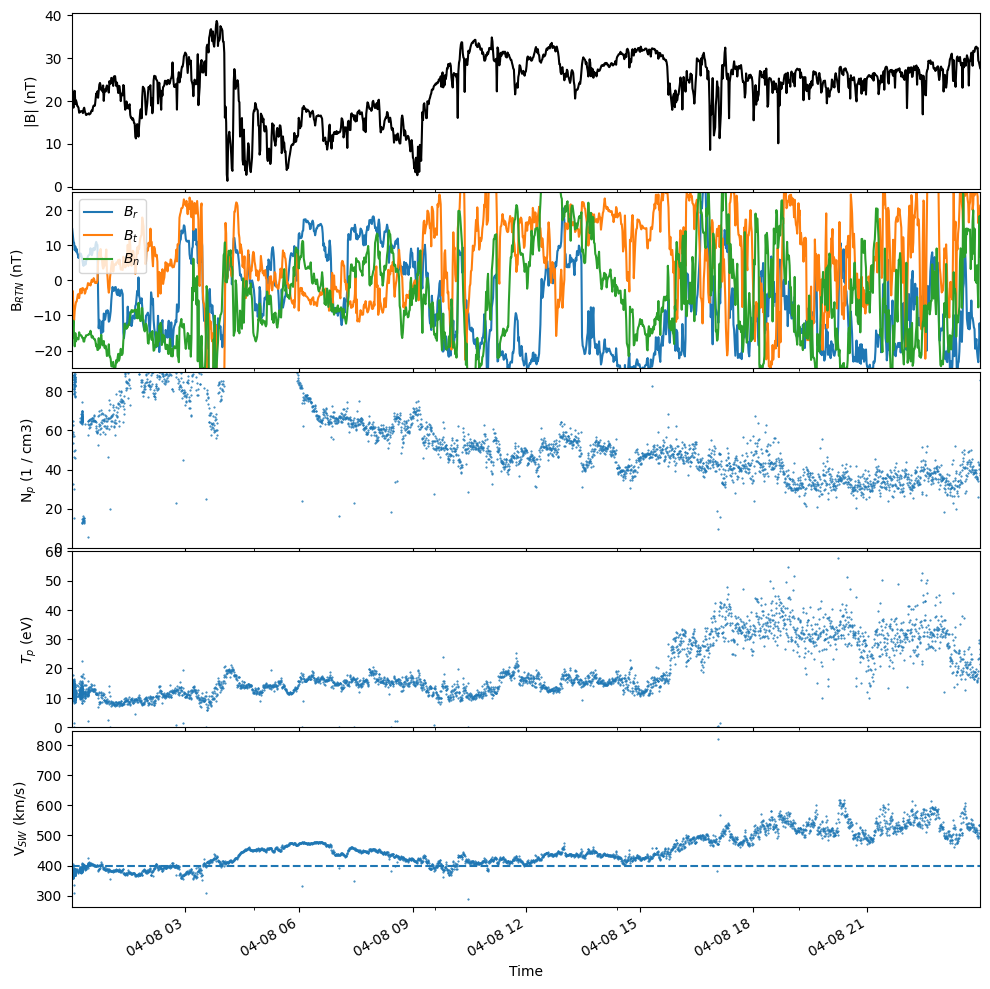

In [12]:
# Plot time series
fig, ax = plt.subplots(5, sharex=True, figsize=(10, 10))

# total B field
psp_fields_mag_clean._data["total_B"].plot(ax=ax[0], color='k')
ax[0].set_ylabel("|B| (nT)")

# B field x, y, z
psp_fields_mag_clean._data[["psp_fld_l2_mag_RTN_1min_0", 
                            "psp_fld_l2_mag_RTN_1min_1", 
                            "psp_fld_l2_mag_RTN_1min_2"]].plot(ax=ax[1])

ax[1].legend(labels=["$B_r$", "$B_t$", "$B_n$"], loc="upper left")
ax[1].set_ylabel("B$_{RTN}$ (nT)")
ax[1].set_ylim(-25, 25)

# proton density
psp_spc._data["np_moment"].plot(ax=ax[2], ls='', marker='.',ms=1)
ax[2].set_ylim(0, 90)
ax[2].set_ylabel("N$_p$ ({:s})".format(psp_spc.quantity("np_moment").unit))

# proton temperature
psp_spc._data["proton_temperature"].plot(ax=ax[3], ls='', marker='.', ms=1)
ax[3].set_ylim(0, 60)
ax[3].set_ylabel("$T_p$ (eV)")

# proton bulk speed
psp_spc._data["bulk_vp_magnitude"].plot(ax=ax[4], marker='.', ls='', ms=1)
ax[4].set_ylabel("V$_{SW}$ (km/s)")
plt.axhline(400, ls="dashed")
    
ax[0].set_xlim(psp_spc.time[0].datetime, psp_spc.time[-1].datetime)
ax[4].set_xlabel("Time")
plt.tight_layout()
plt.subplots_adjust(hspace=0.02)

## Solar Orbiter

In [13]:
# Find Solo datasets
solo_datasets = get_datasets('SOLO')
solo_datasets[solo_datasets["Instruments"] == 'SWA-PAS']

Id,Instruments,Label,Start,End
str41,str60,str249,str24,str24
SOLO_L2_SWA-PAS-EFLUX,SWA-PAS,"Solar Orbiter Level 2 Energy Flux from Solar Wind Analyser (SWA) Proton-Alpha Sensor (PAS) - C.J. Owen (MSSL-UCL, University College London, UK)",2020-07-07T16:43:06.000Z,2025-05-31T23:59:58.000Z
SOLO_L2_SWA-PAS-VDF,SWA-PAS,"Solar Orbiter Level 2 Phase Spase Distribution Function from Solar Wind Analyser (SWA) Proton-Alpha Sensor (PAS) - C.J. Owen (MSSL-UCL, University College London, UK)",2020-07-07T16:43:06.000Z,2025-05-31T23:59:58.000Z
SOLO_L2_SWA-PAS-GRND-MOM,SWA-PAS,"Solar Orbiter Level 2 Ground Calculated Moments Data from Solar Wind Analyser (SWA) Proton-Alpha Sensor (PAS) - C.J. Owen (MSSL-UCL, University College London, UK)",2020-07-07T16:43:06.000Z,2025-05-31T23:59:58.000Z


In [14]:
solo_datasets[solo_datasets["Instruments"] == 'MAG']

Id,Instruments,Label,Start,End
str41,str60,str249,str24,str24
SOLO_L2_MAG-RTN-LL,MAG,"Solar Orbiter L2 Magnetometer Data Derived from Low Latency Data - T. Horbury (The Blackett Laboratory, Imperial College London)",2021-09-05T00:00:03.000Z,2021-09-15T23:59:46.000Z
SOLO_L2_MAG-VSO-NORMAL,MAG,"Solar Orbiter Magnetometer L2 Data - T. Horbury (The Blackett Laboratory, Imperial College London)",2020-12-26T00:00:00.000Z,2025-02-19T23:59:59.000Z
SOLO_L2_MAG-RTN-LL-1-MINUTE,MAG,"Solar Orbiter L2 1-Minute Magnetometer Data Derived from Low Latency Data - T. Horbury (The Blackett Laboratory, Imperial College London)",2021-09-05T00:00:29.000Z,2021-09-15T23:59:30.000Z
SOLO_LL02_MAG,MAG,"Solar Orbiter Level 2 Low Latency Magnetometer Data - T. Horbury (The Blackett Laboratory, Imperial College London)",2020-06-03T14:28:15.000Z,2023-02-13T20:49:37.000Z
SOLO_L2_MAG-VSO-NORMAL-1-MINUTE,MAG,"Solar Orbiter Magnetometer L2 Data - T. Horbury (The Blackett Laboratory, Imperial College London)",2020-12-26T00:00:29.000Z,2022-09-05T23:59:30.000Z
SOLO_L2_MAG-SRF-LL,MAG,"Solar Orbiter L2 Magnetometer Data Derived from Low Latency Data - T. Horbury (The Blackett Laboratory, Imperial College London)",2021-09-05T00:00:03.000Z,2021-09-15T23:59:46.000Z
SOLO_L2_MAG-VSO-BURST,MAG,"Solar Orbiter Magnetometer L2 Data - T. Horbury (The Blackett Laboratory, Imperial College London)",2020-12-26T00:00:00.000Z,2025-02-19T23:59:59.000Z
SOLO_L2_MAG-SRF-BURST,MAG,"Solar Orbiter Level 2 Magnetometer Data in Spacecraft Reference Frame in Burst Mode - T. Horbury (The Blackett Laboratory, Imperial College London)",2020-04-15T00:00:00.000Z,2025-07-31T23:59:59.000Z
SOLO_L2_MAG-RTN-NORMAL,MAG,"Solar Orbiter Level 2 Magnetometer Data in RTN Coordinates in Normal Mode - T. Horbury (The Blackett Laboratory, Imperial College London)",2020-04-15T00:00:00.000Z,2025-07-31T23:59:59.000Z


In [15]:
# Search and download Solar Wind Analyser SWA data (4-second)
res_solo_swa = Fido.search(a.Time(tstart, tend), a.cdaweb.Dataset('SOLO_L2_SWA-PAS-GRND-MOM'))
files_solo_swa = Fido.fetch(res_solo_swa, path=solo_data_path)

# Search and download solo mag data (1-minute)
res_solo_mag = Fido.search(a.Time(tstart, tend), a.cdaweb.Dataset('SOLO_L2_MAG-RTN-NORMAL-1-MINUTE'))
files_solo_mag = Fido.fetch(res_solo_mag, path=solo_data_path)

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.02s/file]


In [16]:
# Create time series for both swa and mag datasets
solo_swa_pas = TimeSeries(files_solo_swa, concatenate=True)
solo_mag = TimeSeries(files_solo_mag, concatenate=True)

In [17]:
total_B_solo = np.sqrt(solo_mag.quantity('B_RTN_0')**2 +
                solo_mag.quantity('B_RTN_1')**2 +
                solo_mag.quantity('B_RTN_2')**2)

solo_mag = solo_mag.add_column("total_B", total_B_solo)

total_v = np.sqrt(solo_swa_pas.quantity('V_RTN_0')**2 +
                solo_swa_pas.quantity('V_RTN_1')**2 +
                solo_swa_pas.quantity('V_RTN_2')**2)

solo_swa_pas = solo_swa_pas.add_column("bulk_sw", total_v)

Plot

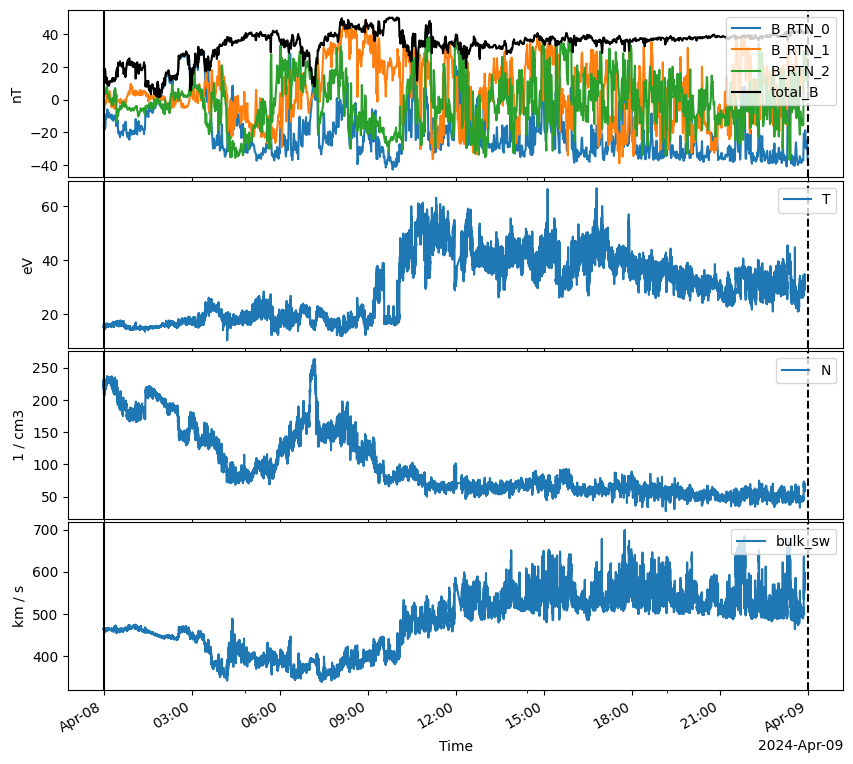

In [32]:
fig, ax = plt.subplots(4, figsize=(10, 10), sharex=True)

solo_mag.plot(columns=['B_RTN_0', 'B_RTN_1', 'B_RTN_2'], axes=ax[0])
solo_mag.plot(columns=['total_B'], axes=ax[0], color='k')
solo_swa_pas.plot(columns=['T'], axes=ax[1])
solo_swa_pas.plot(columns=['N'], axes=ax[2])
solo_swa_pas.plot(columns=['bulk_sw'], axes=ax[3])
ax[3].set_xlabel("Time")


for aa in ax:
    aa.legend(loc="upper right")
    aa.axvline(f"{start}", color='k')
    aa.axvline(f"{end}", color='k', ls="dashed")
    
plt.subplots_adjust(hspace=0.02)

## Ace

In [19]:
# Find Ace datasets
ace_datasets = get_datasets('AC')
ace_datasets[ace_datasets["Instruments"] == 'MAG']

Id,Instruments,Label,Start,End
str13,str9,str119,str24,str24
AC_H2_MFI,MAG,H2 - ACE Magnetic Field 1-Hour Level 2 Data - N. Ness (Bartol Research Institute),1997-09-02T00:00:00.000Z,2025-10-11T23:00:00.000Z
AC_H1_MFI,MAG,H1 - ACE Magnetic Field 4-Minute Level 2 Data - N. Ness (Bartol Research Institute),1997-09-02T00:00:00.000Z,2025-10-11T23:56:00.000Z
AC_H3_MFI,MAG,H3 - ACE Magnetic Field 1-Second Level 2 Data - N. Ness (Bartol Research Institute),1998-01-01T00:00:00.000Z,2025-10-11T23:59:59.000Z
AC_H0_MFI,MAG,H0 - ACE Magnetic Field 16-Second Level 2 Data - N. Ness (Bartol Research Institute),1997-09-02T00:00:12.000Z,2025-10-11T23:59:49.000Z


In [20]:
ace_datasets[ace_datasets["Instruments"] == 'SWEP']

Id,Instruments,Label,Start,End
str13,str9,str119,str24,str24
AC_H2_SWE,SWEP,ACE/SWEPAM Solar Wind Experiment 1-Hour Level 2 Data - D. J. McComas (SWRI),1998-02-04T00:00:00.000Z,2024-06-12T23:00:00.000Z
AC_H0_SWE,SWEP,ACE/SWEPAM Solar Wind Experiment 64-Second Level 2 Data - D. J. McComas (SWRI),1998-02-04T00:00:31.000Z,2024-06-12T23:59:17.000Z


In [21]:
# Search and download ace sw data (64-second)
res_ace_swep = Fido.search(a.Time(tstart, tend), a.cdaweb.Dataset('AC_H0_SWE'))
files_ace_swep = Fido.fetch(res_ace_swep, path=ace_data_path)

# Search and download ace mag data (1-second)
res_ace_mag = Fido.search(a.Time(tstart, tend), a.cdaweb.Dataset('AC_H3_MFI'))
files_ace_mag = Fido.fetch(res_ace_mag, path=ace_data_path)

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

















































































Files Downloaded: 100%|██████████| 2/2 [00:47<00:00, 23.68s/file]


<Axes: xlabel='Epoch', ylabel='km / s'>

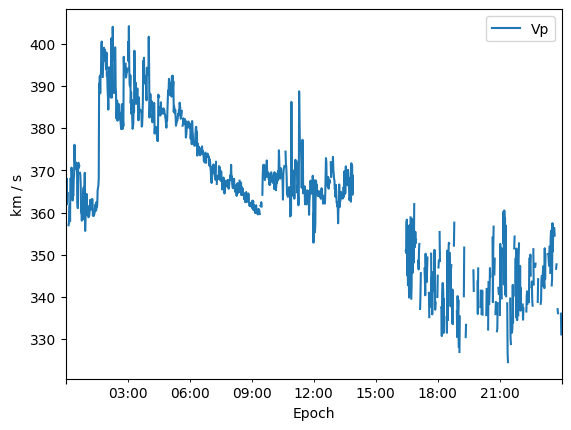

In [22]:
ace_sw = TimeSeries(files_ace_swep, concatenate=True)
ace_mag = TimeSeries(files_ace_mag, concatenate=True)
ace_sw.plot(columns=['Vp'])

Proton Temperature

In [23]:
ace_tpr_ev = ace_sw._data["Tpr"] * kb_eV
ace_sw = ace_sw.add_column("Tpr_eV", ace_tpr_ev)

## Spice Kernels

In [24]:
# Download and initialise spice kernels
solo_kernel_urls = [
    "spk/de421.bsp",
    "spk/solo_ANC_soc-orbit-stp_20200210-20301120_280_V1_00288_V01.bsp",
]
solo_kernel_urls = [f"http://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/{url}"
               for url in solo_kernel_urls]

psp_kernel_url = ["https://spdf.gsfc.nasa.gov/pub/data/psp/ephemeris/spice/ephemerides/spp_nom_20180812_20250831_v040_RO7.bsp"]


kernels = solo_kernel_urls + psp_kernel_url

kernel_files = [cache.download(url) for url in kernels]
spice.initialize(kernel_files)

In [25]:
# define a time array from start to end, minute resolution (multiply by 60 to get seconds)
minute = 1/(24*60)
second = minute/60

obstime = Time(start) + np.arange(0, (Time(end) - Time(start)).jd, minute)

solo_spacecraft = spice.get_body('Solar Orbiter', obstime)
psp_spacecraft = spice.get_body('SOLAR PROBE PLUS', obstime)

solo_spacecraft_hgs = solo_spacecraft.heliographic_stonyhurst
psp_spacecraft_hgs = psp_spacecraft.heliographic_stonyhurst

Distance from Sun

In [26]:
d_unit = 'AU'

solo_mean, solo_min, solo_max = solo_spacecraft_hgs.radius.to(d_unit).mean().value, solo_spacecraft_hgs.radius.to(d_unit).min().value, solo_spacecraft_hgs.radius.to(d_unit).max().value

solo_upp, solo_low = solo_max - solo_mean, solo_mean - solo_min

psp_mean, psp_min, psp_max = psp_spacecraft_hgs.radius.to(d_unit).mean().value, psp_spacecraft_hgs.radius.to(d_unit).min().value, psp_spacecraft_hgs.radius.to(d_unit).max().value

psp_upp, psp_low = psp_max - psp_mean, psp_mean - psp_min

# Step 2: Time Series Comparison between Parker Solar Probe and Solar Orbiter

Comparison of total magnetic field magnitude as well as $B_{RTN}$ components detected by PSP, SolO and ACE over the same time period defined at the beginning of this notebook.

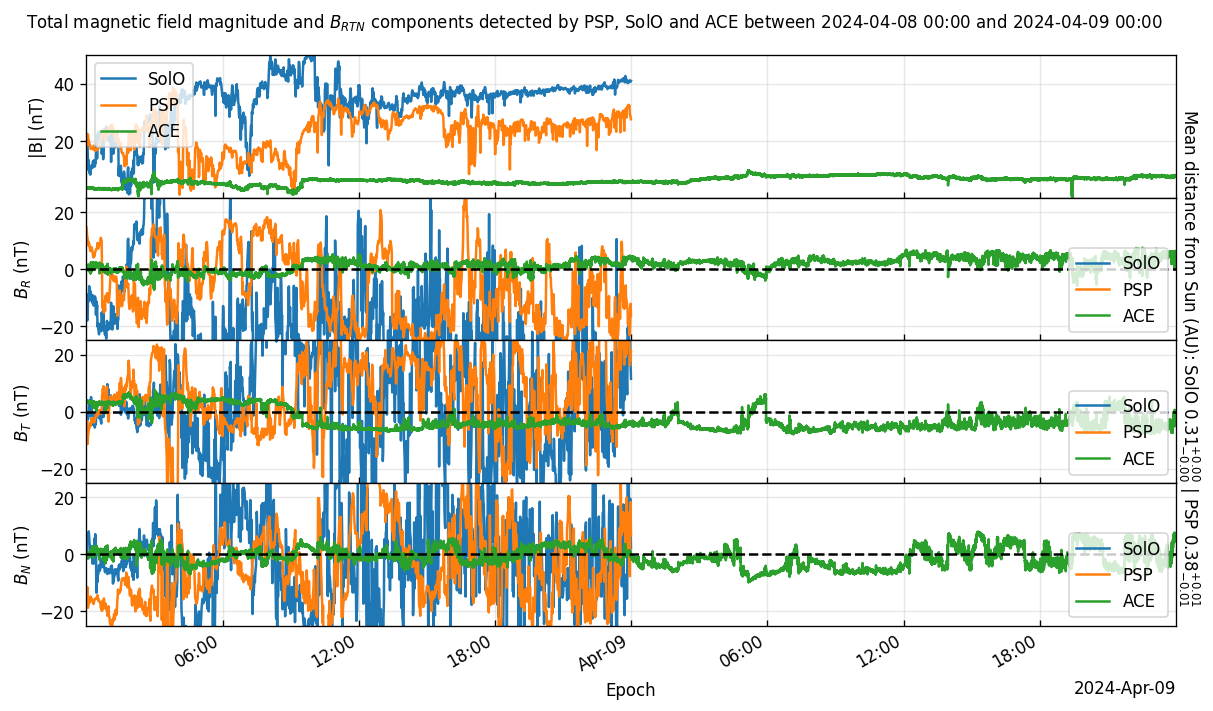

In [33]:
fig, ax = plt.subplots(4, figsize=(10, 6), sharex=True, dpi=120)

min_y = -25
max_y = 25

# Total B magnitude comparison
solo_mag.plot(columns=['total_B'], axes=ax[0])
psp_fields_mag_clean.plot(columns=['total_B'], axes=ax[0])
ace_mag.plot(columns=['Magnitude'], axes=ax[0])
ax[0].set_ylabel("|B| (nT)")
ax[0].legend(labels=["SolO", "PSP", "ACE"], loc="upper left")

# SolO B_RTN
solo_mag.plot(columns=['B_RTN_0'], axes=ax[1])
psp_fields_mag_clean.plot(columns=["psp_fld_l2_mag_RTN_1min_0"], axes=ax[1])
ace_mag.plot(columns=['BRTN_0'], axes=ax[1])
ax[1].set_ylabel("$B_{R}$ (nT)")
ax[1].legend(labels=["SolO", "PSP", "ACE"], loc="lower right")
ax[1].set_ylim(min_y, max_y)
ax[1].axhline(0, c='k', ls='--')

solo_mag.plot(columns=['B_RTN_1'], axes=ax[2])
psp_fields_mag_clean.plot(columns=["psp_fld_l2_mag_RTN_1min_1"], axes=ax[2])
ace_mag.plot(columns=['BRTN_1'], axes=ax[2])
ax[2].set_ylabel("$B_{T}$ (nT)")
ax[2].legend(labels=["SolO", "PSP", "ACE"], loc="lower right")
ax[2].set_ylim(min_y, max_y)
ax[2].axhline(0, c='k', ls='--')

solo_mag.plot(columns=['B_RTN_2'], axes=ax[3])
psp_fields_mag_clean.plot(columns=["psp_fld_l2_mag_RTN_1min_2"], axes=ax[3])
ace_mag.plot(columns=['BRTN_2'], axes=ax[3])
ax[3].set_ylabel("$B_{N}$ (nT)")
ax[3].legend(labels=["SolO", "PSP", "ACE"], loc="lower right")
ax[3].set_ylim(min_y, max_y)
ax[3].axhline(0, c='k', ls='--')

#ax[4].plot(obstime.datetime64, solo_spacecraft_hgs.radius)
#ax[4].plot(obstime.datetime64, psp_spacecraft_hgs.radius)
#ax[4].set_ylabel('Distance from Sun ($R_{sun}$)')

# Remove margins, set inwards ticks and grid
for aa in ax:
    aa.tick_params(axis='x', direction='in')
    aa.margins(x=0, y=0)
    aa.grid('.', alpha=0.3)

fig.text(0.985, 0.5, f'Mean distance from Sun (AU): SolO ${solo_mean:.2f}^{{+{solo_upp:.2f}}}_{{-{solo_low:.2f}}}$ | PSP ${psp_mean:.2f}^{{+{psp_upp:.2f}}}_{{-{psp_low:.2f}}}$', rotation=-90, va='center')

fig.suptitle(f'Total magnetic field magnitude and $B_{{RTN}}$ components detected by PSP, SolO and ACE between {start} and {end}', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(hspace=0)

Comparison of 3 wind parameters: Proton Temperature, Density and Speed as detected by the SWA, SWEAP and SWEP instruments of SolO, PSP and ACE respectively during the same time period as defined in the beginning of this notebook.

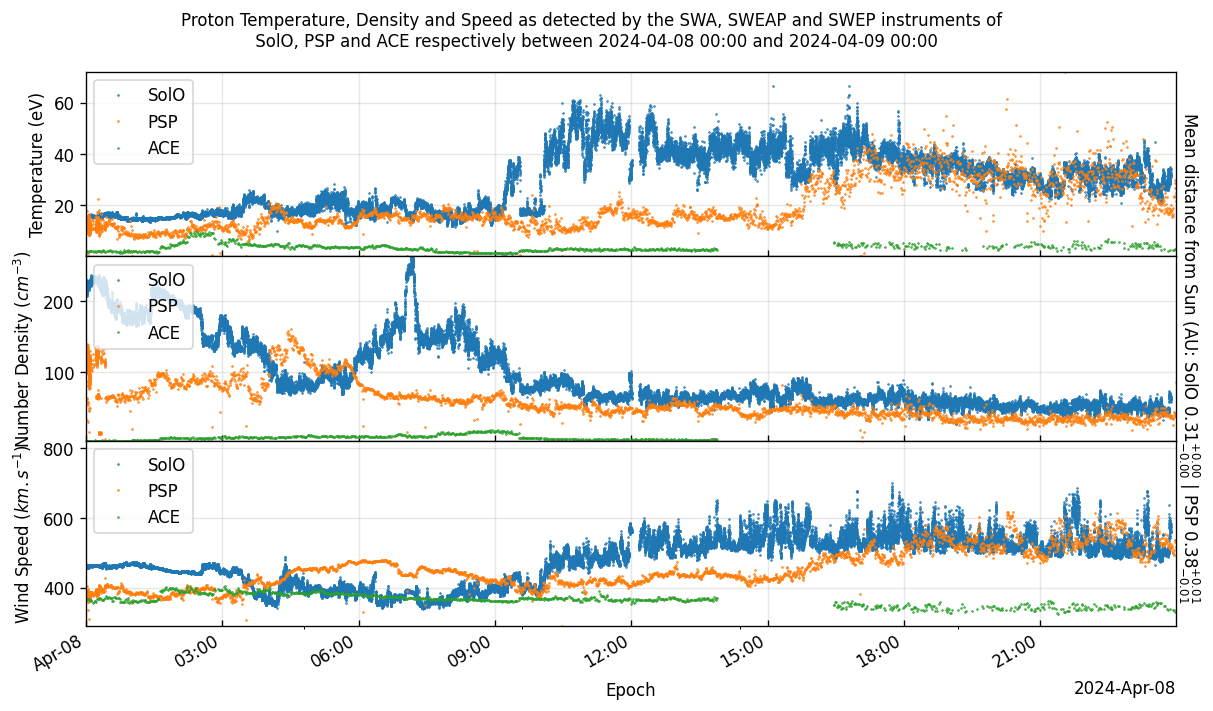

In [34]:
fig, ax = plt.subplots(3, figsize=(10, 6), sharex=True, dpi=120)

# Proton Temperature Comparison
solo_swa_pas.plot(columns=['T'], axes=ax[0], ls='', marker='.', ms=1)
psp_spc.plot(columns=['proton_temperature'], axes=ax[0], ls='', marker='.', ms=1)
ace_sw.plot(columns=['Tpr_eV'], axes=ax[0], ls='', marker='.', ms=1)
ax[0].set_ylabel("Temperature (eV)")

# Proton Density Comparison
solo_swa_pas.plot(columns=['N'], axes=ax[1], ls='', marker='.', ms=1)
psp_spc.plot(columns=["np_moment"], axes=ax[1], ls='', marker='.', ms=1)
ace_sw.plot(columns=['Np'], axes=ax[1], ls='', marker='.', ms=1)
ax[1].set_ylabel("Number Density ($cm^{-3}$)")

# Wind Speed Comparison
solo_swa_pas.plot(columns=['bulk_sw'], axes=ax[2], marker='.', ls='', ms=1)
psp_spc.plot(columns=["bulk_vp_magnitude"], axes=ax[2], marker='.', ls='', ms=1)
ace_sw.plot(columns=['Vp'], axes=ax[2], ls='', marker='.', ms=1)
ax[2].set_ylabel("Wind Speed ($km.s^{-1}$)")

# Remove margins, set inwards ticks, set ticks and legends
for aa in ax:
    aa.tick_params(axis='x', direction='in')
    aa.margins(x=0, y=0)
    aa.grid('.', alpha=0.3)
    aa.legend(labels=["SolO", "PSP", "ACE"], loc="upper left")

fig.text(0.985, 0.5, f'Mean distance from Sun (AU: SolO ${solo_mean:.2f}^{{+{solo_upp:.2f}}}_{{-{solo_low:.2f}}}$ | PSP ${psp_mean:.2f}^{{+{psp_upp:.2f}}}_{{-{psp_low:.2f}}}$', rotation=-90, va='center')

fig.suptitle(f'Proton Temperature, Density and Speed as detected by the SWA, SWEAP and SWEP instruments of \n SolO, PSP and ACE respectively between {start} and {end}', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(hspace=0)

# Step 3: Time Series Histogram

Plot distributions for $V_{sw}$, $N_{p}$, $T_{p}$ and $|B|$ for each spacecraft on the same time window.

Text(0.5, 0.98, 'Distributions for $V_{sw}$, $N_{p}$, $T_{p}$ and $|B|$ for SolO/ACE/PSP between Jul 28th and Jul 31st, 2022')

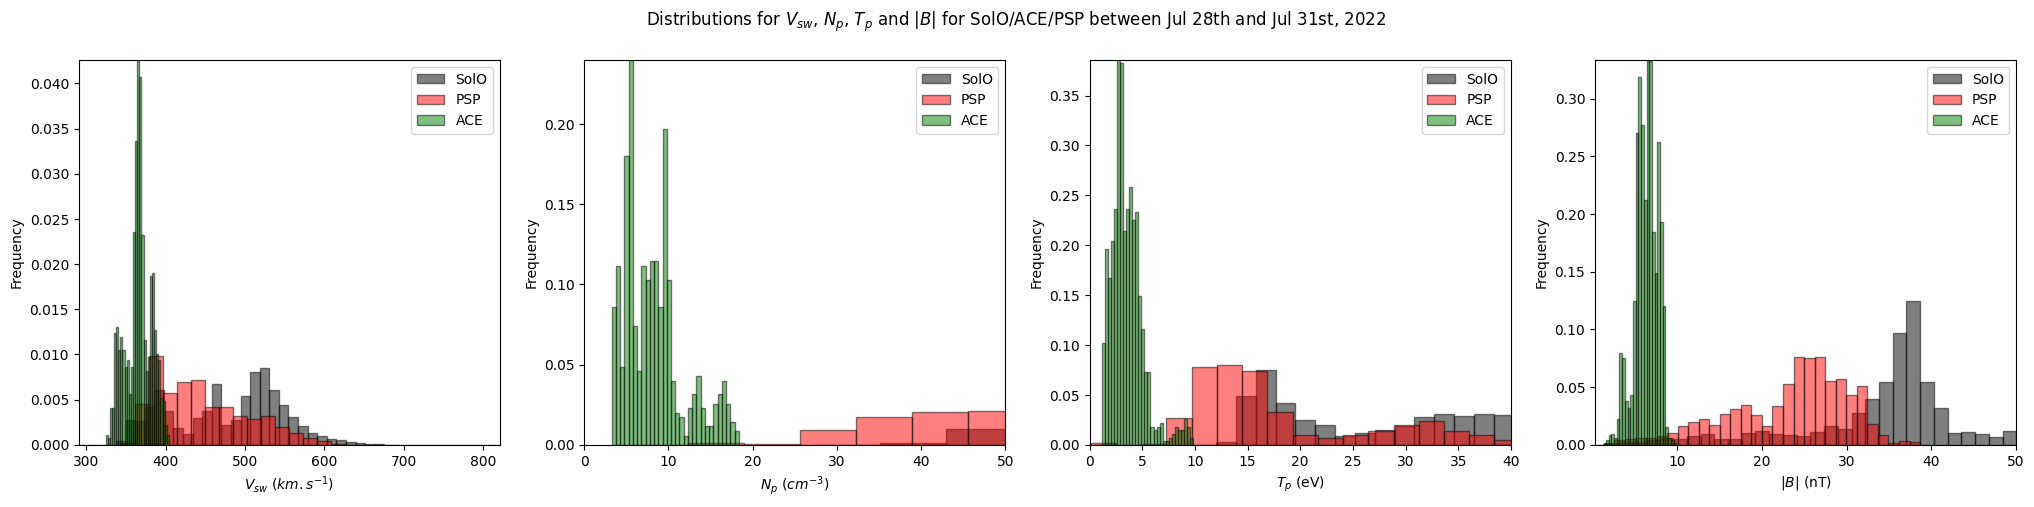

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), dpi=100)

bins = 30
color_solo = 'k'
color_psp = 'r'
color_ace = 'g'
alpha = .5
edgecolor='k'

# Solar wind distribution plot
solo_swa_pas.plot(kind='hist', density=True, columns=['bulk_sw'], axes=ax[0], color=color_solo, bins=bins, alpha=alpha, edgecolor=edgecolor)
psp_spc.plot(kind='hist', density=True, columns=['bulk_vp_magnitude'], axes=ax[0], color=color_psp, bins=bins, alpha=alpha, edgecolor=edgecolor)
ace_sw.plot(kind='hist', density=True, columns=['Vp'], axes=ax[0], color=color_ace, bins=bins, alpha=alpha, edgecolor=edgecolor)
ax[0].set_xlabel("$V_{sw}$ ($km.s^{-1}$)")
ax[0].set_ylabel("Frequency")

# Proton Density distribution plot
solo_swa_pas.plot(kind='hist', density=True, columns=['N'], axes=ax[1], color=color_solo, bins=bins, alpha=alpha, edgecolor=edgecolor)
psp_spc.plot(kind='hist', density=True, columns=['np_moment'], axes=ax[1], color=color_psp, bins=bins, alpha=alpha, edgecolor=edgecolor)
ace_sw.plot(kind='hist', density=True, columns=['Np'], axes=ax[1], color=color_ace, bins=bins, alpha=alpha, edgecolor=edgecolor)
ax[1].set_xlabel("$N_{p}$ ($cm^{-3}$)")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(0, 50)

# Proton Temperature distribution plot
solo_swa_pas.plot(kind='hist', density=True, columns=['T'], axes=ax[2], color=color_solo, bins=bins, alpha=alpha, edgecolor=edgecolor)
psp_spc.plot(kind='hist', density=True, columns=['proton_temperature'], axes=ax[2], color=color_psp, bins=bins, alpha=alpha, edgecolor=edgecolor)
ace_sw.plot(kind='hist', density=True, columns=['Tpr_eV'], axes=ax[2], color=color_ace, bins=bins, alpha=alpha, edgecolor=edgecolor)
ax[2].set_xlabel("$T_{p}$ (eV)")
ax[2].set_ylabel("Frequency")
ax[2].set_xlim(0, 40)

# Magnetic field magnitude distribution plot
solo_mag.plot(kind='hist', density=True, columns=['total_B'], axes=ax[3], color=color_solo, bins=bins, alpha=alpha, edgecolor=edgecolor)
psp_fields_mag_clean.plot(kind='hist', density=True, columns=['total_B'], axes=ax[3], color=color_psp, bins=bins, alpha=alpha, edgecolor=edgecolor)
ace_mag.plot(kind='hist', density=True, columns=['Magnitude'], axes=ax[3], color=color_ace, bins=bins, alpha=alpha, edgecolor=edgecolor)
ax[3].set_xlabel("$|B|$ (nT)")
ax[3].set_ylabel("Frequency")

for aa in ax:
    aa.margins(x=0, y=0)
    aa.legend(labels=["SolO", "PSP", "ACE"])

fig.suptitle('Distributions for $V_{sw}$, $N_{p}$, $T_{p}$ and $|B|$ for SolO/ACE/PSP between Jul 28th and Jul 31st, 2022')

Plot distribution of Solar Wind in different regimes, Slow < 400 $km.s^{-1}$, Intermediate 400 $km.s^{-1}$ < $v_{sw}$ < 600 $km.s^{-1}$ and Fast > 600 $km.s^{-1}$

In [30]:
# in km/s
low_sw = 400
high_sw = 600

psp_slow_sw = psp_spc._data["bulk_vp_magnitude"][psp_spc._data["bulk_vp_magnitude"] < low_sw]
solo_slow_sw = solo_swa_pas._data["bulk_sw"][solo_swa_pas._data["bulk_sw"] < low_sw]
ace_slow_sw = ace_sw._data["Vp"][ace_sw._data["Vp"] < low_sw]

psp_int_sw = psp_spc._data["bulk_vp_magnitude"][((psp_spc._data["bulk_vp_magnitude"] > low_sw)) & (psp_spc._data["bulk_vp_magnitude"] < high_sw)]
solo_int_sw = solo_swa_pas._data["bulk_sw"][(solo_swa_pas._data["bulk_sw"] > low_sw) & (solo_swa_pas._data["bulk_sw"] < high_sw)]
ace_int_sw = ace_sw._data["Vp"][(ace_sw._data["Vp"] > low_sw) & (ace_sw._data["Vp"] < high_sw)]

psp_fast_sw = psp_spc._data["bulk_vp_magnitude"][psp_spc._data["bulk_vp_magnitude"] > high_sw]
solo_fast_sw = solo_swa_pas._data["bulk_sw"][solo_swa_pas._data["bulk_sw"] > high_sw]
ace_fast_sw = ace_sw._data["Vp"][ace_sw._data["Vp"] > high_sw]

Text(0.5, 0.98, 'Distributions for $V_{sw}$ by slow, intermediate and fast wind speed for SolO/ACE/PSP between Jul 28th and Jul 31st, 2022')

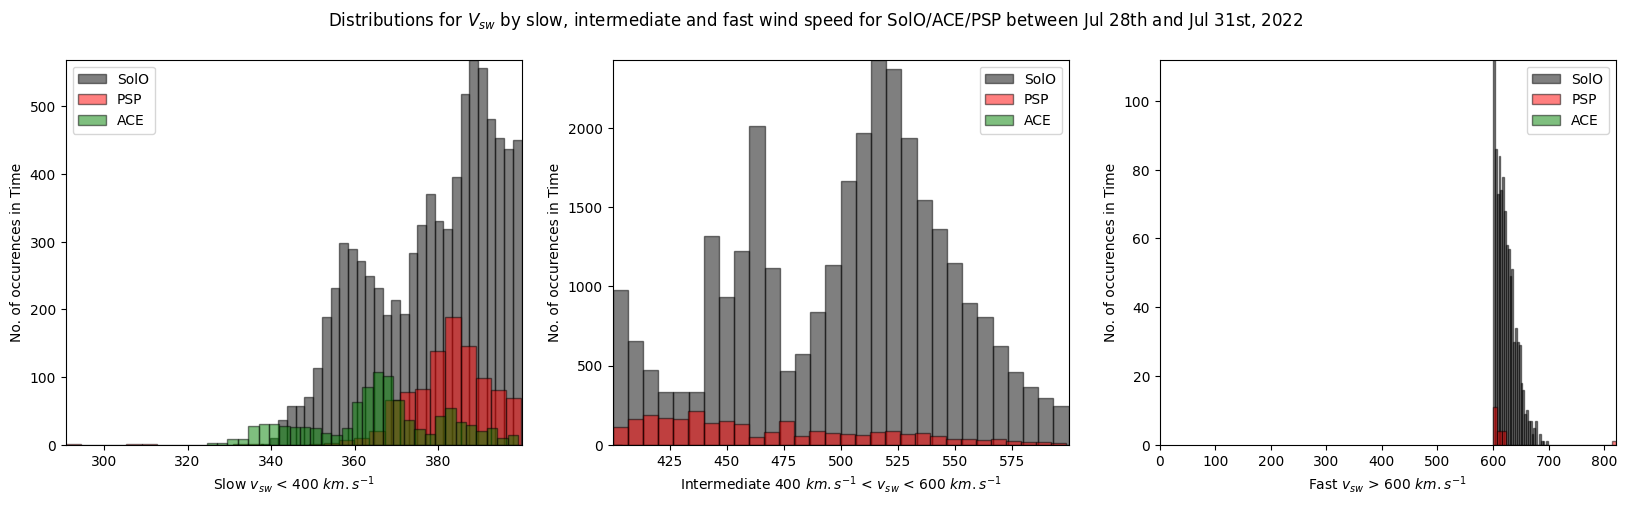

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=100)

solo_slow_sw.plot(kind='hist', ax=ax[0], color=color_solo, bins=bins, alpha=alpha, edgecolor=edgecolor)
psp_slow_sw.plot(kind='hist', ax=ax[0], color=color_psp, bins=bins, alpha=alpha, edgecolor=edgecolor)
ace_slow_sw.plot(kind='hist', ax=ax[0], color=color_ace, bins=bins, alpha=alpha, edgecolor=edgecolor)
ax[0].set_xlabel("Slow $v_{sw}$ < 400 $km.s^{-1}$")
ax[0].set_ylabel("No. of occurences in Time")

solo_int_sw.plot(kind='hist', ax=ax[1], color=color_solo, bins=bins, alpha=alpha, edgecolor=edgecolor)
psp_int_sw.plot(kind='hist', ax=ax[1], color=color_psp, bins=bins, alpha=alpha, edgecolor=edgecolor)
ace_int_sw.plot(kind='hist', ax=ax[1], color=color_ace, bins=bins, alpha=alpha, edgecolor=edgecolor)

ax[1].set_xlabel("Intermediate 400 $km.s^{-1}$ < $v_{sw}$ < 600 $km.s^{-1}$")
ax[1].set_ylabel("No. of occurences in Time")

solo_fast_sw.plot(kind='hist', ax=ax[2], color=color_solo, bins=bins, alpha=alpha, edgecolor=edgecolor)
psp_fast_sw.plot(kind='hist', ax=ax[2], color=color_psp, bins=bins, alpha=alpha, edgecolor=edgecolor)
ace_fast_sw.plot(kind='hist', ax=ax[2], color=color_ace, bins=bins, alpha=alpha, edgecolor=edgecolor)
ax[2].set_xlabel("Fast $v_{sw}$ > 600 $km.s^{-1}$")
ax[2].set_ylabel("No. of occurences in Time")

for aa in ax:
    aa.margins(x=0, y=0)
    aa.legend(labels=["SolO", "PSP", "ACE"])

fig.suptitle('Distributions for $V_{sw}$ by slow, intermediate and fast wind speed for SolO/ACE/PSP between Jul 28th and Jul 31st, 2022')